## Imports

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
import random 
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Reshape, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, Dropout, BatchNormalization

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ten

## Spectral Normalization

In [2]:
#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2D, self).__init__(filters, **kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2DTranspose, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

## Pixel Normalization

In [3]:
class PixelNormalization(Layer):
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate square pixel values
        values = inputs**2.0
        # Calculate the mean pixel values
        mean_values = tf.keras.backend.mean(values, axis=-1, keepdims=True)
        # Ensure the mean is not zero
        mean_values += 1.0e-8
        # Calculate the sqrt of the mean squared value (L2 norm)
        l2 = tf.keras.backend.sqrt(mean_values)
        # Normalize values by the l2 norm
        normalized = inputs / l2
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape
    

## Mini-batch Standard Deviation

In [4]:
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = tf.keras.backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = tf.keras.backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = tf.keras.backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = tf.keras.backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = tf.keras.backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = tf.keras.backend.shape(inputs)
        output = tf.keras.backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = tf.keras.backend.concatenate([inputs, output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

### Utility functions

In [5]:
def get_attributes(filename, how_many):
    attributes = pd.read_csv(filename)
    return np.array(attributes.drop('image_id', axis=1))[:how_many]
    


######### load the dataset images
def load_images(dataset, images_directory, img_shape):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(images_directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    return X

######### select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

######### generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2): # two calsses: 0 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, n_attr))
    return [z_input, labels]


######### use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2)
    # predict outputs
    concat = tf.concat([z_input, labels_input], axis=-1)
    images = generator.predict(concat)
    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

######### load dataset
def load_dataset(how_many, images_directory = 'img_align_celeba_nozip', attr_file = 'list_attr_celeba.csv', img_shape = (178, 218, 3)):  
    celeba_img = np.sort(os.listdir(images_directory))[:how_many]
    images = load_images(celeba_img, images_directory, img_shape)
    attributes = get_attributes(attr_file, how_many)
    attributes[attributes<=0] = 0
    dataset = [images, attributes]
    return dataset

    
######### plot the generated images
def plot_generated_images(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

## Models definition

In [6]:
def discriminator(n_attr, filters = 128, kernel_size = 4, in_shape=(64,64,3)):

    in_img = Input(shape=(in_shape))
    
    # 64 x 64 x FILTERS
    disc = SNConv2D(filters=filters, kernel_size=kernel_size, 
        strides=(2,2), padding='same', kernel_initializer="orthogonal",
        spectral_normalization=True)(in_img)
    disc = LeakyReLU(alpha=0.2)(disc)
    
    # 32 x 32 x FILTERS
    disc = SNConv2D(filters=filters, kernel_size=kernel_size,
    strides=(2,2), padding='same', kernel_initializer="orthogonal",
    spectral_normalization=True)(disc)
    disc = LeakyReLU(alpha=0.2)(disc)
   
    # 16 x 16 x FILTERS
    disc = SNConv2D(filters=filters, kernel_size=kernel_size,
    strides=(2,2), padding='same', kernel_initializer="orthogonal",
    spectral_normalization=True)(disc)
    disc = LeakyReLU(alpha=0.2)(disc)
   
    # 8 x 8 x FILTERS
    disc = SNConv2D(filters=filters, kernel_size=kernel_size,
    strides=(2,2), padding='same', kernel_initializer="orthogonal",
    spectral_normalization=True)(disc)
    disc = LeakyReLU(alpha=0.2)(disc)
    
    # apply MinibatchStdev 
    disc = MinibatchStdev()(disc)
    
    # current: 4 x 4 x FILTERS
    disc = GlobalAveragePooling2D()(disc)
    
    # output about fake/real image:
    out1 = Dense(1, activation='sigmoid')(disc)
    # output about attributes:
    out2 = Dense(n_attr, activation='softmax')(disc)
    
    # define model
    model = Model(in_img, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"],
        optimizer=opt, metrics=['accuracy'])
    return model

def generator(latent_dim, n_attr, filters=128, kernel_size=4, strides=(2, 2)):

    in_gen = Input(shape=(latent_dim + n_attr,))
    gen = Dense(4 * 4 * filters)(in_gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, filters))(gen)
    
    # 4x4 -> 8x8
    gen = SNConv2DTranspose(filters=filters, kernel_size=kernel_size, 
        strides=strides, padding='same', kernel_initializer="orthogonal",
        spectral_normalization=True)(gen)
    gen = PixelNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 8x8 -> 16x16
    gen = SNConv2DTranspose(filters=filters, kernel_size=kernel_size,
        strides=strides, padding='same', kernel_initializer="orthogonal",
        spectral_normalization=True)(gen)
    gen = PixelNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 16x16 -> 32x32
    gen = SNConv2DTranspose(filters=filters, kernel_size=kernel_size,
        strides=strides, padding='same', kernel_initializer="orthogonal",
        spectral_normalization=False)(gen)
    gen = PixelNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 32x32 -> 64x64
    gen = SNConv2DTranspose(filters=filters, kernel_size=kernel_size, 
        strides=strides, padding='same', kernel_initializer="orthogonal",
        spectral_normalization=True)(gen)
    gen = PixelNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 64 x 64 x FILTERS -> 64 x 64 x 3
    image = SNConv2D(filters=3, kernel_size=kernel_size, activation='tanh',
        padding='same', kernel_initializer="orthogonal",
        spectral_normalization=True)(gen)

    # define model
    model = Model(in_gen, image)
    return model

def ACGAN(g_model, d_model):
    img = g_model.output
    d_model.trainable = False
    valid, target_label = d_model(img)
    
    noise_plus_label = g_model.input
    model = Model(noise_plus_label, [valid, target_label])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
        optimizer=opt)
    return model

## Function for training the gan

In [7]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size):
    bat_per_epo = int(dataset[0].shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
           
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)   
           
            d_metrics1 = d_model.train_on_batch(X_real, [y_real, labels_real])
           
            d_loss1 = d_metrics1[0]
           
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
          
            d_metrics2 = d_model.train_on_batch(X_fake, [y_fake, labels])
            
            d_loss2 = d_metrics2[0]
          
            [z_input, z_labels] = generate_latent_points(latent_dim, batch_size, n_attr, n_classes=2)
          
            y_gan = np.ones((batch_size, 1))
         
            concat = tf.concat([z_input, z_labels], axis=-1)
            g_metrics = gan_model.train_on_batch(concat, [y_gan, z_labels])
            g_loss = g_metrics[0]
            
        # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        
        # save the generator model
        g_model.save('cgan/cgan_generator' +str(i+j)+'.h5')
        model = load_model('cgan/cgan_generator' +str(i+j)+'.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D, 'PixelNormalization': PixelNormalization, 'MinibatchStdev':MinibatchStdev})
        latent_points, labels = generate_latent_points(latent_dim, 100, n_attr)
        labels = np.array([0,0,1,0, 0,0,0,1,0,0, 0,0,0,0,0, 1,0,0,1,0, 0,0,0,0,1, 0,0,0,0,1, 0,1,0,0,1, 0,0,0,0,1]) 
        labels = labels.reshape(1, 40)
        labelsx = labels
        labels2x = labels
        for i in range(99):
            labelsx = np.vstack((labelsx, labels2x))
        
        concat = tf.concat([latent_points, labelsx], axis=-1)
        # generate images
        X = g_model.predict(concat)
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        plot_generated_images(X, 3)
        

### Attribute selection

In [8]:
# list the indexes of the attributes to be used to condition the generator:
dict_attributes = {1: '5_o_Clock_Shadow', 2: 'Arched_Eyebrows', 3: 'Attractive', 4: 'Bags_Under_Eyes', 
                   5: 'Bald', 6: 'Bangs', 7: 'Big_Lips', 8: 'Big_Nose', 9: 'Black_Hair', 10: 'Blond_Hair', 
                   11: 'Blurry', 12: 'Brown_Hair', 13: 'Bushy_Eyebrows', 14: 'Chubby', 15: 'Double_Chin', 
                   16: 'Eyeglasses', 17: 'Goatee', 18: 'Gray_Hair', 19: 'Heavy_Makeup', 20: 'High_Cheekbones', 
                   21: 'Male', 22: 'Mouth_Slightly_Open', 23: 'Mustache', 24: 'Narrow_Eyes', 25: 'No_Beard', 
                   26: 'Oval_Face', 27: 'Pale_Skin', 28: 'Pointy_Nose', 29: 'Receding_Hairline', 30: 'Rosy_Cheeks', 
                   31: 'Sideburns', 32: 'Smiling', 33: 'Straight_Hair', 34: 'Wavy_Hair', 35: 'Wearing_Earrings', 
                   36: 'Wearing_Hat', 37: 'Wearing_Lipstick', 38: 'Wearing_Necklace', 39: 'Wearing_Necktie', 40: 'Young'}


### Parameters

In [9]:
# number of images to use for training
how_many = 180000

# size of the latent space
latent_dim = 128

# number of images per batch
batch_size = 64

# number of epochs
n_epochs = 100

# number of attributes per image
n_attr = 40

# just 2 possible value for each attribute
n_classes=2

### Models

In [10]:
# create the discriminator
d_model = discriminator(n_attr)

# create the generator
g_model = generator(latent_dim, n_attr)

# create the gan combined model
gan_model = ACGAN(g_model, d_model)

TypeError: You are attempting to use Python control flow in a layer that was not declared to be dynamic. Pass `dynamic=True` to the class constructor.
Encountered error:
"""
Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.
"""

### Load dataset

In [15]:
dataset = load_dataset(how_many)

# Traininig

>1, 11250/11250, d1=1.104, d2=1.143 g=1.154


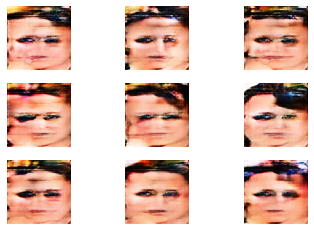

>2, 11250/11250, d1=1.054, d2=0.823 g=0.885


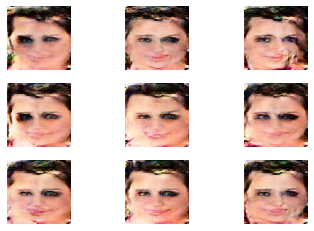

>3, 11250/11250, d1=0.979, d2=0.872 g=0.853


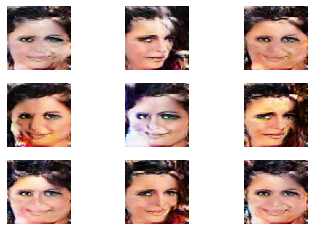

>4, 11250/11250, d1=1.062, d2=0.823 g=0.881


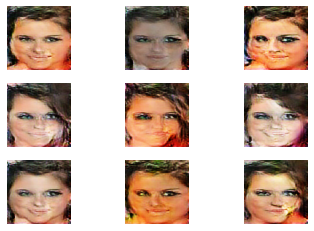

>5, 11250/11250, d1=0.991, d2=0.856 g=0.818


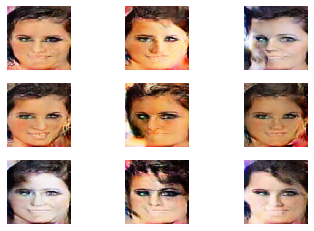

>6, 11250/11250, d1=0.984, d2=0.798 g=0.849


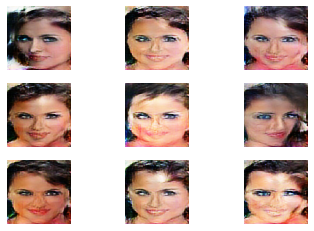

>7, 11250/11250, d1=1.053, d2=0.693 g=0.859


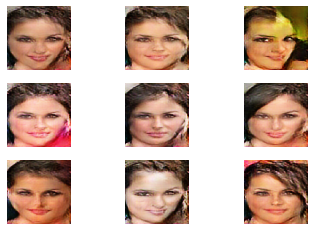

>8, 11250/11250, d1=1.097, d2=0.752 g=0.836


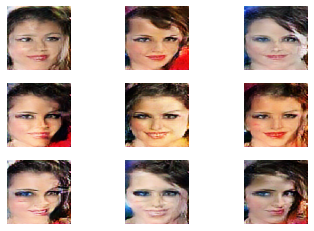

>9, 11250/11250, d1=1.031, d2=0.806 g=0.902


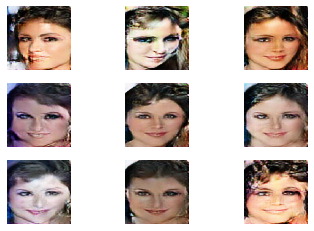

>10, 11250/11250, d1=1.030, d2=0.827 g=0.803


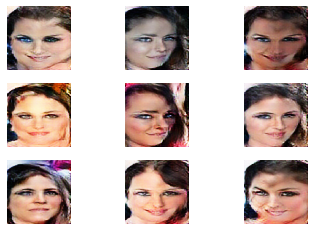

>11, 11250/11250, d1=0.959, d2=0.703 g=0.844


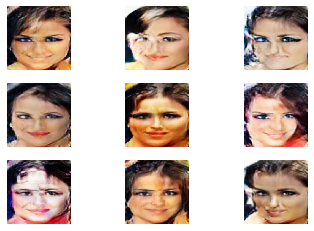

>12, 11250/11250, d1=1.003, d2=0.793 g=0.854


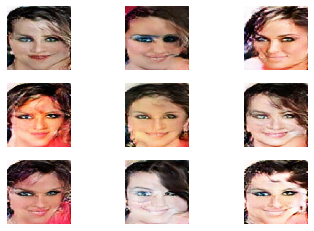

>13, 11250/11250, d1=1.098, d2=0.753 g=0.868


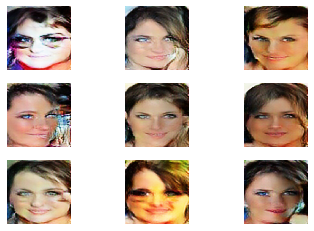

>14, 11250/11250, d1=0.986, d2=0.794 g=0.810


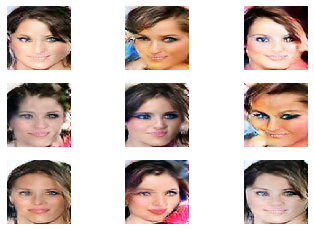

>15, 11250/11250, d1=1.017, d2=0.773 g=0.841


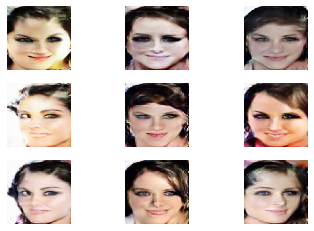

>16, 11250/11250, d1=0.961, d2=0.750 g=0.812


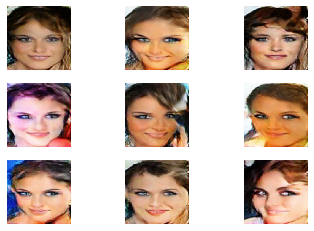

>17, 11250/11250, d1=0.948, d2=0.754 g=0.845


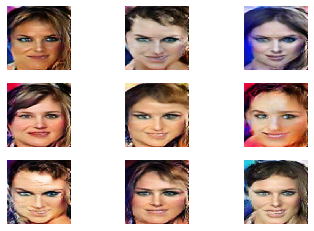

>18, 11250/11250, d1=0.984, d2=0.730 g=0.824


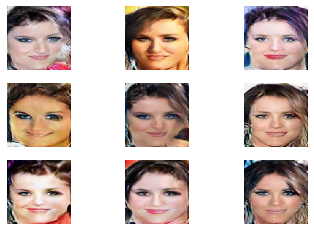

>19, 11250/11250, d1=0.931, d2=0.753 g=0.881


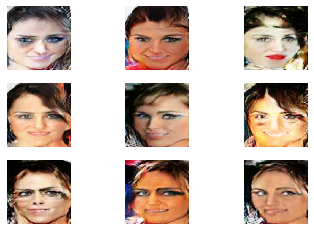

>20, 11250/11250, d1=1.024, d2=0.855 g=0.812


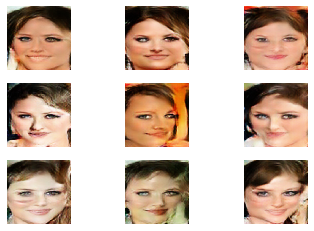

>21, 11250/11250, d1=1.052, d2=0.766 g=0.828


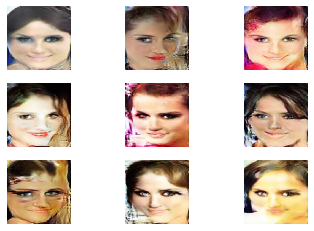

>22, 11250/11250, d1=0.971, d2=0.791 g=0.797


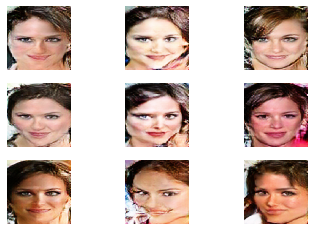

>23, 11250/11250, d1=1.002, d2=0.846 g=0.797


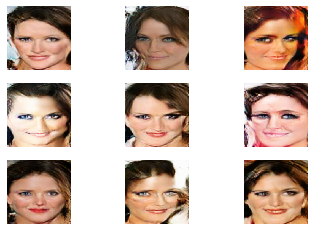

>24, 11250/11250, d1=0.910, d2=0.779 g=0.830


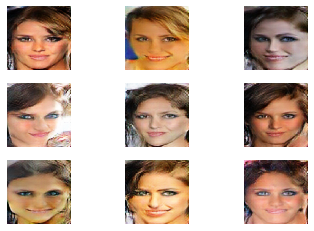

>25, 11250/11250, d1=0.861, d2=0.801 g=0.804


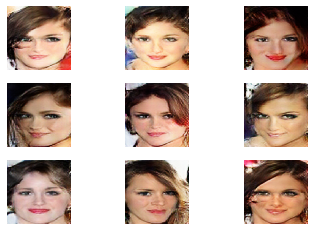

>26, 11250/11250, d1=0.909, d2=0.839 g=0.853


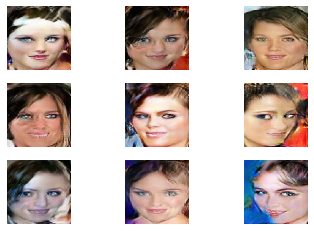

>27, 11250/11250, d1=0.976, d2=0.819 g=0.813


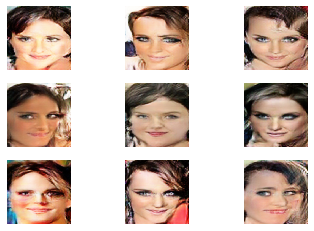

>28, 11250/11250, d1=0.907, d2=0.727 g=0.822


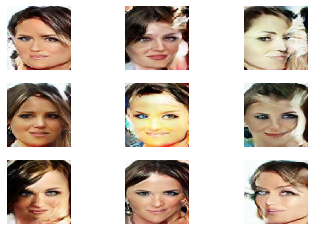

>29, 11250/11250, d1=1.084, d2=0.814 g=0.849


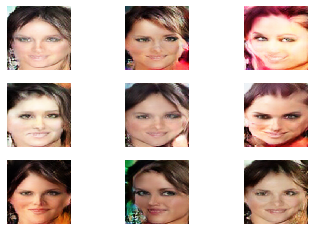

>30, 11250/11250, d1=0.918, d2=0.729 g=0.874


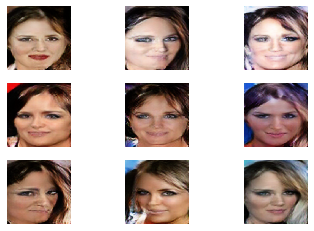

>31, 11250/11250, d1=0.908, d2=0.883 g=0.841


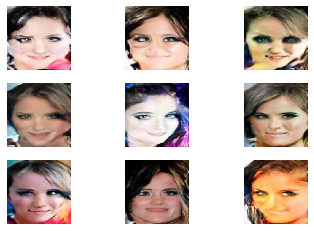

>32, 11250/11250, d1=0.883, d2=0.677 g=0.860


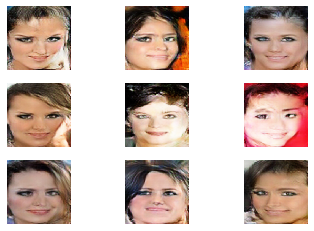

>33, 11250/11250, d1=0.988, d2=0.728 g=0.838


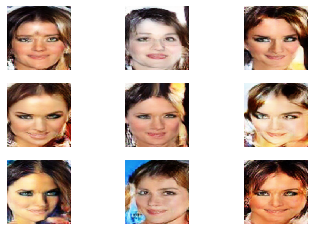

>34, 11250/11250, d1=0.962, d2=0.728 g=0.851


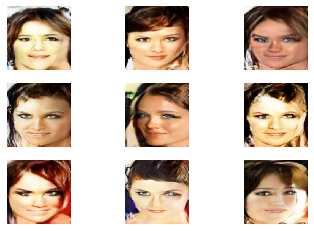

>35, 11250/11250, d1=1.122, d2=0.809 g=0.852


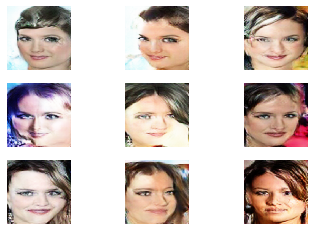

>36, 11250/11250, d1=0.873, d2=0.790 g=0.881


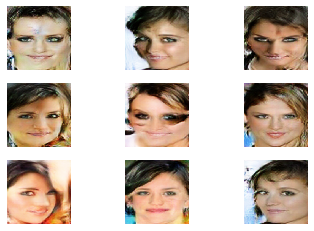

>37, 11250/11250, d1=0.923, d2=0.780 g=0.857


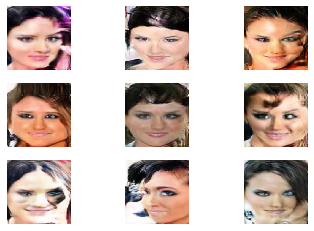

>38, 11250/11250, d1=1.105, d2=0.701 g=0.919


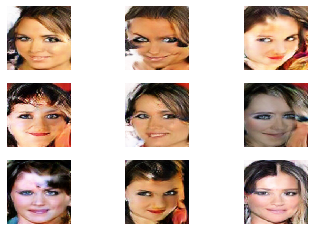

>39, 11250/11250, d1=0.928, d2=0.725 g=0.867


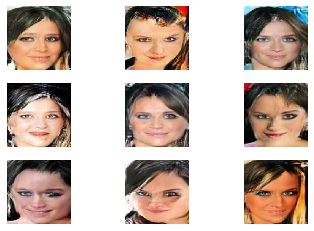

>40, 11250/11250, d1=0.974, d2=0.791 g=0.824


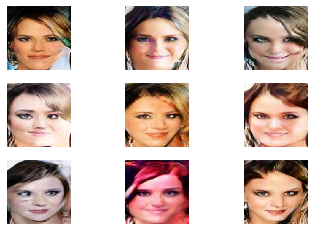

>41, 11250/11250, d1=1.045, d2=0.797 g=0.878


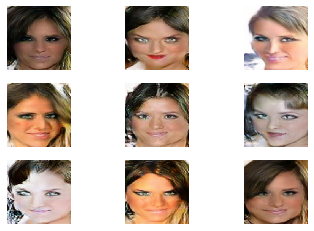

>42, 11250/11250, d1=1.008, d2=0.734 g=0.838


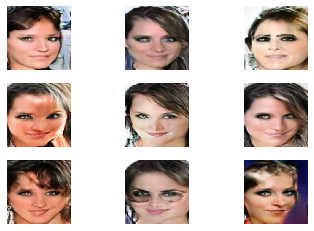

>43, 11250/11250, d1=0.882, d2=0.698 g=0.869


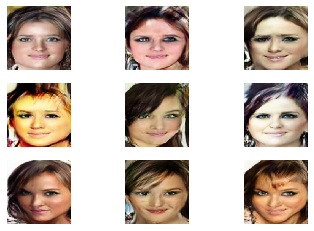

>44, 11250/11250, d1=1.091, d2=0.821 g=0.937


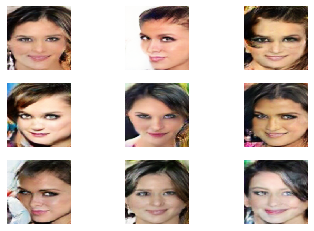

>45, 11250/11250, d1=0.853, d2=0.709 g=0.895


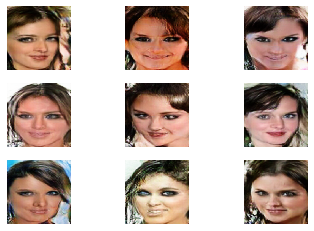

>46, 11250/11250, d1=0.931, d2=0.710 g=0.885


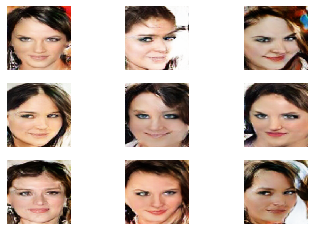

>47, 11250/11250, d1=0.899, d2=0.681 g=0.928


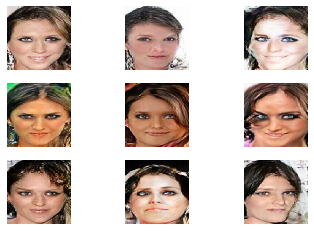

>48, 11250/11250, d1=0.965, d2=0.689 g=0.878


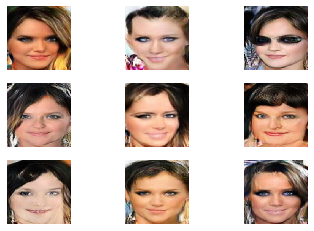

>49, 11250/11250, d1=0.774, d2=0.720 g=1.009


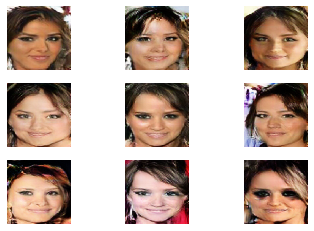

>50, 11250/11250, d1=0.922, d2=0.863 g=0.902


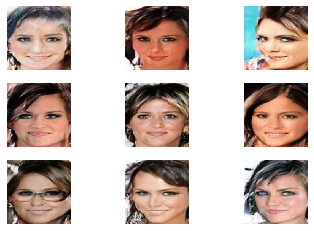

>51, 11250/11250, d1=1.068, d2=0.718 g=0.955


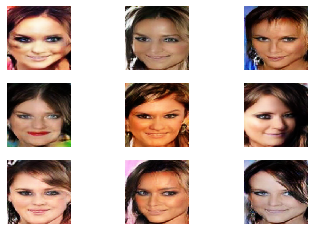

>52, 11250/11250, d1=1.005, d2=0.748 g=0.953


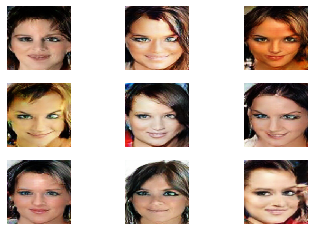

>53, 11250/11250, d1=1.078, d2=0.704 g=0.978


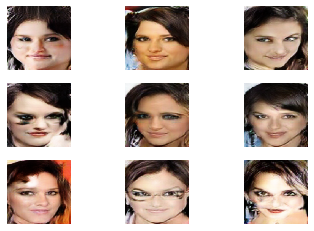

>54, 11250/11250, d1=0.918, d2=0.697 g=0.927


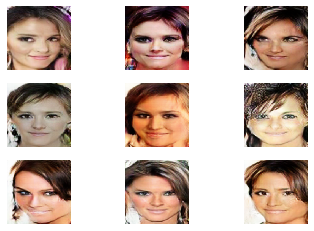

>55, 11250/11250, d1=0.993, d2=0.823 g=1.063


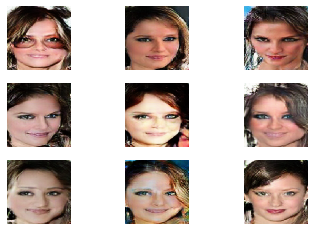

>56, 11250/11250, d1=0.971, d2=0.635 g=0.956


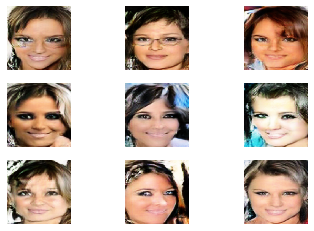

>57, 11250/11250, d1=0.933, d2=0.717 g=0.878


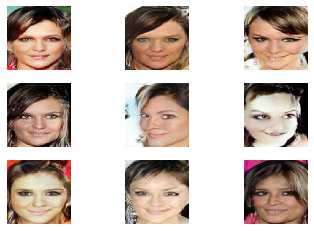

>58, 11250/11250, d1=0.880, d2=0.761 g=0.982


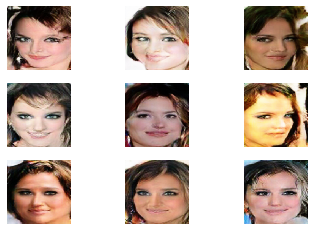

>59, 11250/11250, d1=0.890, d2=0.770 g=0.873


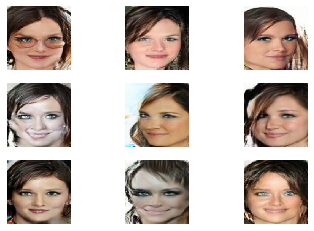

>60, 11250/11250, d1=0.902, d2=0.687 g=1.100


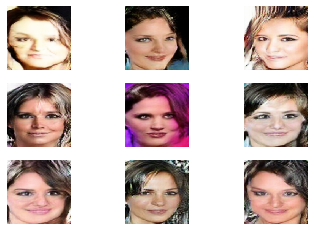

>61, 11250/11250, d1=0.785, d2=0.766 g=0.891


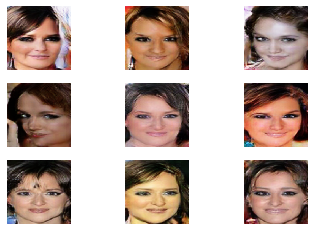

>62, 11250/11250, d1=0.746, d2=0.652 g=1.082


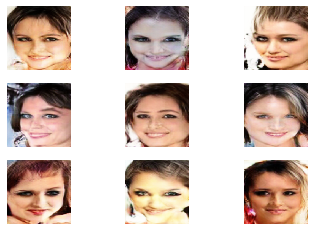

>63, 11250/11250, d1=0.730, d2=0.734 g=0.958


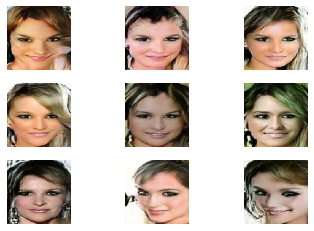

>64, 11250/11250, d1=0.900, d2=0.618 g=1.013


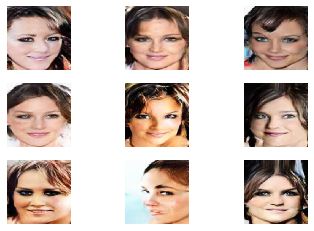

>65, 11250/11250, d1=0.935, d2=0.816 g=0.929


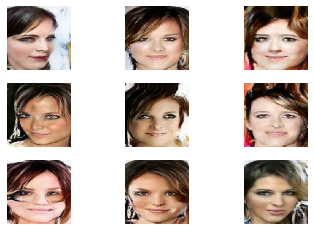

ResourceExhaustedError:  OOM when allocating tensor with shape[16,512,9,9] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2DBackpropInput (defined at <ipython-input-7-82bf9a296645>:26) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_on_batch_24769]

Errors may have originated from an input operation.
Input Source operations connected to node Conv2DBackpropInput:
 model_5/model_3/sn_conv2d_12/truediv_2 (defined at <ipython-input-2-28d0aa4796f4>:52)

Function call stack:
train_on_batch


In [16]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size);

# CGAN FID

In [ ]:
# example of calculating the frechet inception distance in Keras for cifar10
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import load_model
from skimage.transform import resize
from keras.datasets import cifar10

def get_attributes(filename, how_many, random_integers_list):
    attributes = pd.read_csv(filename).drop('image_id', axis=1)
    attributes = attributes.iloc[random_integers_list, :]
    return attributes

def load_images(dataset, images_directory, img_shape):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(images_directory + "/" + myid, target_size=img_shape[:2])
        image = img_to_array(image)
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    return X


######### LOAD FID DATASET:
def load_fid_dataset(how_many, images_directory = '/content/drive/My Drive/img_align_celeba_nozip', attr_file = '/content/drive/My Drive/list_attr_celeba.csv', img_shape = (178, 218, 3)):  
    # from 20k images I select "how_many" images for the fid. Note that "how_many" must be 10k
    random_integers_list = random.sample(range(20000), how_many)
    celeba_img = np.sort(os.listdir(images_directory))
    images_id = celeba_img[random_integers_list]
    images = load_images(images_id, images_directory, img_shape)
    attributes = get_attributes(attr_file, how_many, random_integers_list)
    attributes[attributes<=0] = 0
    fid_dataset = [images, attributes]
    return fid_dataset

######### LOAD GROUN TRUTH LABELS FOR FID:
def load_groundtruth_labels(how_many, attr_file = '/content/drive/My Drive/list_attr_celeba.csv'):  
    # the 200000 could also be the exact number of images of celeba
    random_integers_list = random.sample(range(20000), how_many)
    attributes = get_attributes(attr_file, how_many, random_integers_list)
    attributes[attributes<=0] = 0
    return attributes

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2): # two calsses: 0 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim) # (64, 100)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, n_attr)) # HERE (n_samples, 40)
    return [z_input, labels]

  

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighborinterpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# list the indexes of the attributes to be used to condition the generator:
dict_attributes = {1: '5_o_Clock_Shadow', 2: 'Arched_Eyebrows', 3: 'Attractive', 4: 'Bags_Under_Eyes', 
                   5: 'Bald', 6: 'Bangs', 7: 'Big_Lips', 8: 'Big_Nose', 9: 'Black_Hair', 10: 'Blond_Hair', 
                   11: 'Blurry', 12: 'Brown_Hair', 13: 'Bushy_Eyebrows', 14: 'Chubby', 15: 'Double_Chin', 
                   16: 'Eyeglasses', 17: 'Goatee', 18: 'Gray_Hair', 19: 'Heavy_Makeup', 20: 'High_Cheekbones', 
                   21: 'Male', 22: 'Mouth_Slightly_Open', 23: 'Mustache', 24: 'Narrow_Eyes', 25: 'No_Beard', 
                   26: 'Oval_Face', 27: 'Pale_Skin', 28: 'Pointy_Nose', 29: 'Receding_Hairline', 30: 'Rosy_Cheeks', 
                   31: 'Sideburns', 32: 'Smiling', 33: 'Straight_Hair', 34: 'Wavy_Hair', 35: 'Wearing_Earrings', 
                   36: 'Wearing_Hat', 37: 'Wearing_Lipstick', 38: 'Wearing_Necklace', 39: 'Wearing_Necktie', 40: 'Young'}


def FID(how_many, generator_file, latent_dim, n_attr, input_shape=(299,299,3), n_classes = 2):
    print('Start calculating FID...')
    
    images1, _ = load_fid_dataset(how_many) # look at this, what range should be?
    print('Loaded dataset')
    my_generator = load_model(generator_file, custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D, 'PixelNormalization':PixelNormalization})

    latent_points , labels =  generate_latent_points(latent_dim, how_many, n_attr)
    labels = load_groundtruth_labels(how_many)
    images2 = my_generator.predict(tf.concat([latent_points, labels], axis=-1))
    # from [-1, 1] to [0. 255]
    images2 = (images2 * 127.5) + 127.5
    print('Loaded groundtruth')
    # prepare the inception v3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=input_shape[:3])
    print('Loaded', images1.shape, images2.shape)

    # convert integer to floating point values
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    
    # resize images
    images1 = scale_images(images1, input_shape)
    images2 = scale_images(images2, input_shape)
    print('Scaled', images1.shape, images2.shape)
    
    # pre-process images
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    print('Preprocessed', images1.shape, images2.shape)

    # calculate fid
    fid = calculate_fid(model, images1, images2)
    print('FID: %.3f' % fid)
    
FID(10000, '/content/drive/My Drive/cgan_100epoch.h5', latent_dim=128, n_attr=40)